In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes option price"""
    if T <= 0:
        if option_type == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price

In [3]:
def simulate_stock_path(S0, mu, sigma, T, N):
    """
    Simulate a single stock price path using geometric Brownian motion
    
    Parameters:
    - S0: Initial stock price
    - mu: Drift rate
    - sigma: Volatility
    - T: Time to maturity
    - N: Number of time steps
    
    Returns:
    - times: Array of time points
    - prices: Array of stock prices
    """
    dt = T / N
    times = np.linspace(0, T, N + 1)
    
    # Generate random normal increments
    Z = np.random.standard_normal(N)
    
    # Calculate log returns
    log_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    
    # Calculate stock prices
    prices = np.zeros(N + 1)
    prices[0] = S0
    prices[1:] = S0 * np.exp(np.cumsum(log_returns))
    
    return times, prices

In [4]:
def black_scholes_delta(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes delta"""
    if T <= 0:
        if option_type == 'call':
            return 1.0 if S > K else 0.0
        else:
            return -1.0 if S < K else 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    if option_type == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

In [5]:
def simulate_delta_hedging(S0, K, T, r, sigma, mu, N, option_type='call', 
                           bid_ask_spread=0):
    """
    Simulate delta hedging strategy
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free rate
    - sigma: Volatility
    - mu: Drift rate (real-world)
    - N: Number of rebalancing periods
    - option_type: 'call' or 'put'
    - bid_ask_spread: Bid-ask spread as fraction of stock price
    
    Returns:
    - Dictionary with simulation results
    """
    dt = T / N
    times = np.linspace(0, T, N + 1)
    
    # Initialize arrays
    stock_prices = np.zeros(N + 1)
    deltas = np.zeros(N + 1)
    cash = np.zeros(N + 1)
    portfolio_values = np.zeros(N + 1)
    
    # Initial conditions
    stock_prices[0] = S0
    tau = T
    deltas[0] = black_scholes_delta(S0, K, tau, r, sigma, option_type)
    initial_option_value = black_scholes_price(S0, K, tau, r, sigma, option_type)
    
    # Account for transaction costs
    transaction_cost = bid_ask_spread * S0 * abs(deltas[0])
    cash[0] = initial_option_value - deltas[0] * S0 - transaction_cost
    portfolio_values[0] = cash[0] + deltas[0] * S0
    
    # Simulate path
    for i in range(1, N + 1):
        # Update time to maturity
        tau = T - i * dt
        
        # Update cash with interest
        cash[i] = cash[i-1] * np.exp(r * dt)
        
        # Simulate stock price
        Z = np.random.standard_normal()
        stock_prices[i] = stock_prices[i-1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )
        
        # Rebalance (except at maturity)
        if i < N:
            # Calculate new delta
            deltas[i] = black_scholes_delta(stock_prices[i], K, tau, r, sigma, option_type)
            
            # Trading cost
            delta_change = deltas[i] - deltas[i-1]
            transaction_cost = bid_ask_spread * stock_prices[i] * abs(delta_change)
            
            # Update cash after rebalancing
            cash[i] = cash[i] - delta_change * stock_prices[i] - transaction_cost
        else:
            # At maturity, hold previous delta
            deltas[i] = deltas[i-1]
        
        # Portfolio value
        portfolio_values[i] = cash[i] + deltas[i] * stock_prices[i]
    
    # Calculate payoff and hedge error
    if option_type == 'call':
        option_payoff = max(stock_prices[-1] - K, 0)
    else:
        option_payoff = max(K - stock_prices[-1], 0)
    
    final_portfolio_value = portfolio_values[-1]
    hedge_error = final_portfolio_value - option_payoff
    
    return {
        'times': times,
        'stock_prices': stock_prices,
        'deltas': deltas,
        'cash': cash,
        'portfolio_values': portfolio_values,
        'option_payoff': option_payoff,
        'final_portfolio_value': final_portfolio_value,
        'hedge_error': hedge_error
    }

In [6]:
def simulate_zero_one_strategy(S0, K, T, r, sigma, mu, N, option_type='call'):
    """
    Simulate zero/one hedging strategy
    - Buy 1 share when S crosses K from below
    - Sell when S crosses K from above
    - For out-of-the-money call (K > S0), start with 0 shares
    """
    dt = T / N
    times = np.linspace(0, T, N + 1)
    
    stock_prices = np.zeros(N + 1)
    shares = np.zeros(N + 1)
    cash = np.zeros(N + 1)
    portfolio_values = np.zeros(N + 1)
    
    stock_prices[0] = S0
    
    # Initial position: start with theoretical option value in cash
    # For zero/one strategy, we're replicating the option payoff
    initial_option_value = black_scholes_price(S0, K, T, r, sigma, option_type)
    
    if option_type == 'call':
        if S0 >= K:
            # Already in the money - buy 1 share
            shares[0] = 1
            cash[0] = initial_option_value - S0
        else:
            # Out of the money - start with 0 shares
            shares[0] = 0
            cash[0] = initial_option_value
    else:
        # Put option
        if S0 <= K:
            shares[0] = -1  # Short 1 share
            cash[0] = initial_option_value + S0
        else:
            shares[0] = 0
            cash[0] = initial_option_value
    
    portfolio_values[0] = cash[0] + shares[0] * stock_prices[0]
    
    for i in range(1, N + 1):
        # Update cash with interest
        cash[i] = cash[i-1] * np.exp(r * dt)
        
        # Simulate stock price
        Z = np.random.standard_normal()
        stock_prices[i] = stock_prices[i-1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )
        
        # Check for crossing strike price
        if option_type == 'call':
            if stock_prices[i-1] < K and stock_prices[i] >= K:
                # Cross from below - buy 1 share
                shares[i] = 1
                cash[i] = cash[i] - stock_prices[i]
            elif stock_prices[i-1] >= K and stock_prices[i] < K:
                # Cross from above - sell 1 share (if we have one)
                if shares[i-1] > 0:
                    shares[i] = 0
                    cash[i] = cash[i] + stock_prices[i]
                else:
                    shares[i] = 0
            else:
                shares[i] = shares[i-1]
        else:
            # Put option logic
            if stock_prices[i-1] > K and stock_prices[i] <= K:
                # Cross from above - short 1 share
                shares[i] = -1
                cash[i] = cash[i] + stock_prices[i]
            elif stock_prices[i-1] <= K and stock_prices[i] > K:
                # Cross from below - cover short (if we have one)
                if shares[i-1] < 0:
                    shares[i] = 0
                    cash[i] = cash[i] - stock_prices[i]
                else:
                    shares[i] = 0
            else:
                shares[i] = shares[i-1]
        
        # Portfolio value
        portfolio_values[i] = cash[i] + shares[i] * stock_prices[i]
    
    # Calculate final value
    if option_type == 'call':
        option_payoff = max(stock_prices[-1] - K, 0)
    else:
        option_payoff = max(K - stock_prices[-1], 0)
    
    final_portfolio_value = portfolio_values[-1]
    hedge_error = final_portfolio_value - option_payoff
    
    return {
        'times': times,
        'stock_prices': stock_prices,
        'shares': shares,
        'cash': cash,
        'portfolio_values': portfolio_values,
        'option_payoff': option_payoff,
        'final_portfolio_value': final_portfolio_value,
        'hedge_error': hedge_error
    }


# ============================================================================
# Analysis Functions
# ============================================================================

def run_monte_carlo_simulation(S0, K, T, r, sigma, mu, N, num_paths=10000, 
                                option_type='call', bid_ask_spread=0):
    """Run Monte Carlo simulation for delta hedging"""
    hedge_errors = []
    final_values = []
    option_payoffs = []
    
    for _ in range(num_paths):
        result = simulate_delta_hedging(S0, K, T, r, sigma, mu, N, 
                                       option_type, bid_ask_spread)
        hedge_errors.append(result['hedge_error'])
        final_values.append(result['final_portfolio_value'])
        option_payoffs.append(result['option_payoff'])
    
    return np.array(hedge_errors), np.array(final_values), np.array(option_payoffs)


def convergence_analysis(S0, K, T, r, sigma, mu, N_values, num_paths=5000, 
                         option_type='call'):
    """Analyze convergence as N increases"""
    results = []
    
    for N in N_values:
        dt = T / N
        hedge_errors, _, _ = run_monte_carlo_simulation(
            S0, K, T, r, sigma, mu, N, num_paths, option_type
        )
        
        mean_error = np.mean(hedge_errors)
        variance = np.var(hedge_errors)
        std_dev = np.std(hedge_errors)
        
        results.append({
            'N': N,
            'dt': dt,
            'mean_error': mean_error,
            'variance': variance,
            'std_dev': std_dev
        })
    
    return pd.DataFrame(results)


def analyze_drift_impact(S0, K, T, r, sigma, mu_values, N, num_paths=5000,
                         option_type='call'):
    """Analyze impact of drift (mu) on hedging performance"""
    results = []
    
    for mu in mu_values:
        hedge_errors, final_values, _ = run_monte_carlo_simulation(
            S0, K, T, r, sigma, mu, N, num_paths, option_type
        )
        
        results.append({
            'mu': mu,
            'mean_error': np.mean(hedge_errors),
            'variance': np.var(hedge_errors),
            'std_dev': np.std(hedge_errors),
            'mean_final_value': np.mean(final_values)
        })
    
    return pd.DataFrame(results)


def analyze_bid_ask_impact(S0, K, T, r, sigma, mu, N, spread_values, 
                           num_paths=5000, option_type='call'):
    """Analyze impact of bid-ask spread"""
    results = []
    
    for spread in spread_values:
        hedge_errors, final_values, _ = run_monte_carlo_simulation(
            S0, K, T, r, sigma, mu, N, num_paths, option_type, spread
        )
        
        results.append({
            'bid_ask_spread': spread,
            'mean_error': np.mean(hedge_errors),
            'variance': np.var(hedge_errors),
            'std_dev': np.std(hedge_errors),
            'mean_final_value': np.mean(final_values)
        })
    
    return pd.DataFrame(results)


# ============================================================================
# Zero/One Strategy Analysis Functions
# ============================================================================

def run_monte_carlo_zero_one(S0, K, T, r, sigma, mu, N, num_paths=10000, 
                              option_type='call'):
    """Run Monte Carlo simulation for zero/one hedging strategy"""
    hedge_errors = []
    final_values = []
    option_payoffs = []
    
    for _ in range(num_paths):
        result = simulate_zero_one_strategy(S0, K, T, r, sigma, mu, N, option_type)
        hedge_errors.append(result['hedge_error'])
        final_values.append(result['final_portfolio_value'])
        option_payoffs.append(result['option_payoff'])
    
    return np.array(hedge_errors), np.array(final_values), np.array(option_payoffs)


def convergence_analysis_zero_one(S0, K, T, r, sigma, mu, N_values, num_paths=5000, 
                                   option_type='call'):
    """Analyze convergence of zero/one strategy as N increases"""
    results = []
    
    for N in N_values:
        dt = T / N
        hedge_errors, _, _ = run_monte_carlo_zero_one(
            S0, K, T, r, sigma, mu, N, num_paths, option_type
        )
        
        mean_error = np.mean(hedge_errors)
        variance = np.var(hedge_errors)
        std_dev = np.std(hedge_errors)
        
        results.append({
            'N': N,
            'dt': dt,
            'mean_error': mean_error,
            'variance': variance,
            'std_dev': std_dev
        })
    
    return pd.DataFrame(results)


def analyze_drift_impact_zero_one(S0, K, T, r, sigma, mu_values, N, num_paths=5000,
                                   option_type='call'):
    """Analyze impact of drift (mu) on zero/one strategy performance"""
    results = []
    
    for mu in mu_values:
        hedge_errors, final_values, _ = run_monte_carlo_zero_one(
            S0, K, T, r, sigma, mu, N, num_paths, option_type
        )
        
        results.append({
            'mu': mu,
            'mean_error': np.mean(hedge_errors),
            'variance': np.var(hedge_errors),
            'std_dev': np.std(hedge_errors),
            'mean_final_value': np.mean(final_values)
        })
    
    return pd.DataFrame(results)


# ============================================================================
# Visualization Functions
# ============================================================================
def plot_sample_paths(S0, K, T, r, sigma, mu, N, num_paths=5, option_type='call', save_path='sample_paths.png'):
    """Plot sample stock price paths"""
    plt.figure(figsize=(12, 6))
    
    for i in range(num_paths):
        result = simulate_delta_hedging(S0, K, T, r, sigma, mu, N, option_type)
        plt.plot(result['times'], result['stock_prices'], alpha=0.7, 
                label=f'Path {i+1}')
    
    plt.axhline(y=K, color='r', linestyle='--', label='Strike Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title(f'Sample Stock Price Paths (N={N})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()


def plot_hedge_error_distribution(hedge_errors, theoretical_price, save_path='hedge_error_distribution.png'):
    """Plot distribution of hedge errors"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(hedge_errors, bins=50, density=True, alpha=0.7, edgecolor='black')
    axes[0].axvline(x=np.mean(hedge_errors), color='r', linestyle='--', 
                   label=f'Mean: ${np.mean(hedge_errors):.4f}')
    axes[0].set_xlabel('Hedge Error ($)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Distribution of Hedge Errors')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(hedge_errors, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot (Normal Distribution)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()
    
    # Print statistics
    print(f"\nHedge Error Statistics:")
    print(f"  Mean: ${np.mean(hedge_errors):.4f}")
    print(f"  Std Dev: ${np.std(hedge_errors):.4f}")
    print(f"  Variance: {np.var(hedge_errors):.6f}")
    print(f"  Min: ${np.min(hedge_errors):.4f}")
    print(f"  Max: ${np.max(hedge_errors):.4f}")
    print(f"\nTheoretical Option Price: ${theoretical_price:.4f}")


def plot_convergence(convergence_df, save_path='convergence_plots.png'):
    """Plot convergence analysis results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean error vs dt
    axes[0].plot(convergence_df['dt'], convergence_df['mean_error'], 'o-', 
                linewidth=2, markersize=8, color='blue')
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero Error')
    axes[0].set_xlabel('Δt (Time Step)')
    axes[0].set_ylabel('Mean Hedge Error ($)')
    axes[0].set_title('Convergence: Mean Error vs Time Step')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Variance vs dt
    axes[1].plot(convergence_df['dt'], convergence_df['variance'], 'o-', 
                linewidth=2, markersize=8, color='green')
    axes[1].set_xlabel('Δt (Time Step)')
    axes[1].set_ylabel('Variance of Hedge Error')
    axes[1].set_title('Convergence: Variance vs Time Step')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()

def plot_drift_impact(drift_df, r=0.04, save_path='drift_impact.png'):
    """Plot impact of drift on hedging performance"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Variance vs mu
    axes[0].plot(drift_df['mu'], drift_df['variance'], 'o-', 
                linewidth=2, markersize=8, color='orange')
    axes[0].axvline(x=r, color='r', linestyle='--', alpha=0.6, 
                   label=f'Risk-free rate (r={r})')
    axes[0].set_xlabel('μ (Drift Rate)')
    axes[0].set_ylabel('Variance of Hedge Error')
    axes[0].set_title('Impact of Drift: Variance vs μ')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Mean error vs mu
    axes[1].plot(drift_df['mu'], drift_df['mean_error'], 'o-', 
                linewidth=2, markersize=8, color='purple')
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5, 
                   label='Zero Error')
    axes[1].axvline(x=r, color='r', linestyle='--', alpha=0.6, 
                   label=f'Risk-free rate (r={r})')
    axes[1].set_xlabel('μ (Drift Rate)')
    axes[1].set_ylabel('Mean Hedge Error ($)')
    axes[1].set_title('Impact of Drift: Mean Error vs μ')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()

# Also add this function for the bid-ask spread plot
def plot_bid_ask_impact(spread_df, save_path='bid_ask_impact.png'):
    """Plot impact of transaction costs on hedging error"""
    plt.figure(figsize=(10, 6))
    plt.plot(spread_df['bid_ask_spread'] * 100, spread_df['std_dev'], 
            'o-', linewidth=2, markersize=8)
    plt.xlabel('Bid-Ask Spread (%)')
    plt.ylabel('Std Dev of Hedge Error ($)')
    plt.title('Impact of Transaction Costs on Hedging Error')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()


# ============================================================================
# Zero/One Strategy Visualization Functions
# ============================================================================

def plot_zero_one_sample_paths(S0, K, T, r, sigma, mu, N, num_paths=5, 
                                option_type='call', save_path='zero_one_sample_paths.png'):
    """Plot sample stock price paths with zero/one strategy"""
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    for i in range(num_paths):
        result = simulate_zero_one_strategy(S0, K, T, r, sigma, mu, N, option_type)
        
        # Plot stock prices
        axes[0].plot(result['times'], result['stock_prices'], alpha=0.7, 
                    label=f'Path {i+1}')
        
        # Plot shares held
        axes[1].step(result['times'], result['shares'], alpha=0.7, 
                    where='post', label=f'Path {i+1}')
    
    axes[0].axhline(y=K, color='r', linestyle='--', label='Strike Price')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Stock Price')
    axes[0].set_title(f'Zero/One Strategy: Sample Stock Price Paths (N={N})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    axes[1].axhline(y=1, color='green', linestyle='--', alpha=0.5, label='1 Share')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Shares Held')
    axes[1].set_title('Zero/One Strategy: Shares Held Over Time')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(-0.1, 1.5)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()


def plot_zero_one_hedge_error_distribution(hedge_errors, theoretical_price, 
                                            save_path='zero_one_hedge_error_distribution.png'):
    """Plot distribution of zero/one strategy hedge errors"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(hedge_errors, bins=50, density=True, alpha=0.7, edgecolor='black')
    axes[0].axvline(x=np.mean(hedge_errors), color='r', linestyle='--', 
                   label=f'Mean: ${np.mean(hedge_errors):.4f}')
    axes[0].set_xlabel('Hedge Error ($)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Zero/One Strategy: Distribution of Hedge Errors')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(hedge_errors, dist="norm", plot=axes[1])
    axes[1].set_title('Zero/One Strategy: Q-Q Plot (Normal Distribution)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()
    
    # Print statistics
    print(f"\nZero/One Strategy Hedge Error Statistics:")
    print(f"  Mean: ${np.mean(hedge_errors):.4f}")
    print(f"  Std Dev: ${np.std(hedge_errors):.4f}")
    print(f"  Variance: {np.var(hedge_errors):.6f}")
    print(f"  Min: ${np.min(hedge_errors):.4f}")
    print(f"  Max: ${np.max(hedge_errors):.4f}")
    print(f"\nTheoretical Option Price: ${theoretical_price:.4f}")


def plot_zero_one_convergence(convergence_df, save_path='zero_one_convergence_plots.png'):
    """Plot convergence analysis results for zero/one strategy"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean error vs dt
    axes[0].plot(convergence_df['dt'], convergence_df['mean_error'], 'o-', 
                linewidth=2, markersize=8, color='blue')
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero Error')
    axes[0].set_xlabel('Δt (Time Step)')
    axes[0].set_ylabel('Mean Hedge Error ($)')
    axes[0].set_title('Zero/One Strategy: Mean Error vs Time Step')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Variance vs dt
    axes[1].plot(convergence_df['dt'], convergence_df['variance'], 'o-', 
                linewidth=2, markersize=8, color='green')
    axes[1].set_xlabel('Δt (Time Step)')
    axes[1].set_ylabel('Variance of Hedge Error')
    axes[1].set_title('Zero/One Strategy: Variance vs Time Step')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()


def plot_zero_one_drift_impact(drift_df, r=0.04, save_path='zero_one_drift_impact.png'):
    """Plot impact of drift on zero/one strategy performance"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Variance vs mu
    axes[0].plot(drift_df['mu'], drift_df['variance'], 'o-', 
                linewidth=2, markersize=8, color='orange')
    axes[0].axvline(x=r, color='r', linestyle='--', alpha=0.6, 
                   label=f'Risk-free rate (r={r})')
    axes[0].set_xlabel('μ (Drift Rate)')
    axes[0].set_ylabel('Variance of Hedge Error')
    axes[0].set_title('Zero/One Strategy: Variance vs μ')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Mean error vs mu
    axes[1].plot(drift_df['mu'], drift_df['mean_error'], 'o-', 
                linewidth=2, markersize=8, color='purple')
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5, 
                   label='Zero Error')
    axes[1].axvline(x=r, color='r', linestyle='--', alpha=0.6, 
                   label=f'Risk-free rate (r={r})')
    axes[1].set_xlabel('μ (Drift Rate)')
    axes[1].set_ylabel('Mean Hedge Error ($)')
    axes[1].set_title('Zero/One Strategy: Mean Error vs μ')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()


def plot_comparison_delta_vs_zero_one(delta_df, zero_one_df, save_path='comparison_delta_vs_zero_one.png'):
    """Compare delta hedging vs zero/one strategy"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Variance comparison
    axes[0].plot(delta_df['dt'], delta_df['variance'], 'o-', 
                linewidth=2, markersize=8, color='blue', label='Delta Hedging')
    axes[0].plot(zero_one_df['dt'], zero_one_df['variance'], 's-', 
                linewidth=2, markersize=8, color='red', label='Zero/One Strategy')
    axes[0].set_xlabel('Δt (Time Step)')
    axes[0].set_ylabel('Variance of Hedge Error')
    axes[0].set_title('Comparison: Variance vs Time Step')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_yscale('log')  # Log scale for better visualization
    
    # Mean error comparison
    axes[1].plot(delta_df['dt'], delta_df['mean_error'], 'o-', 
                linewidth=2, markersize=8, color='blue', label='Delta Hedging')
    axes[1].plot(zero_one_df['dt'], zero_one_df['mean_error'], 's-', 
                linewidth=2, markersize=8, color='red', label='Zero/One Strategy')
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Δt (Time Step)')
    axes[1].set_ylabel('Mean Hedge Error ($)')
    axes[1].set_title('Comparison: Mean Error vs Time Step')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    plt.show()


DISCRETE DELTA HEDGING SIMULATOR

Parameters:
  S0 = $100, K = $100, T = 1 year(s)
  σ = 0.3, μ = 0.1, r = 0.04
  Option Type: CALL
  Rebalancing Periods: N = 4 (Δt = 0.25)

Theoretical Black-Scholes Price: $13.7533

----------------------------------------------------------------------
PART 1: BASIC MONTE CARLO SIMULATION
----------------------------------------------------------------------
Number of simulated paths: 10000
Mean final portfolio value: $18.1586
Figure saved to: hedge_error_distribution.png


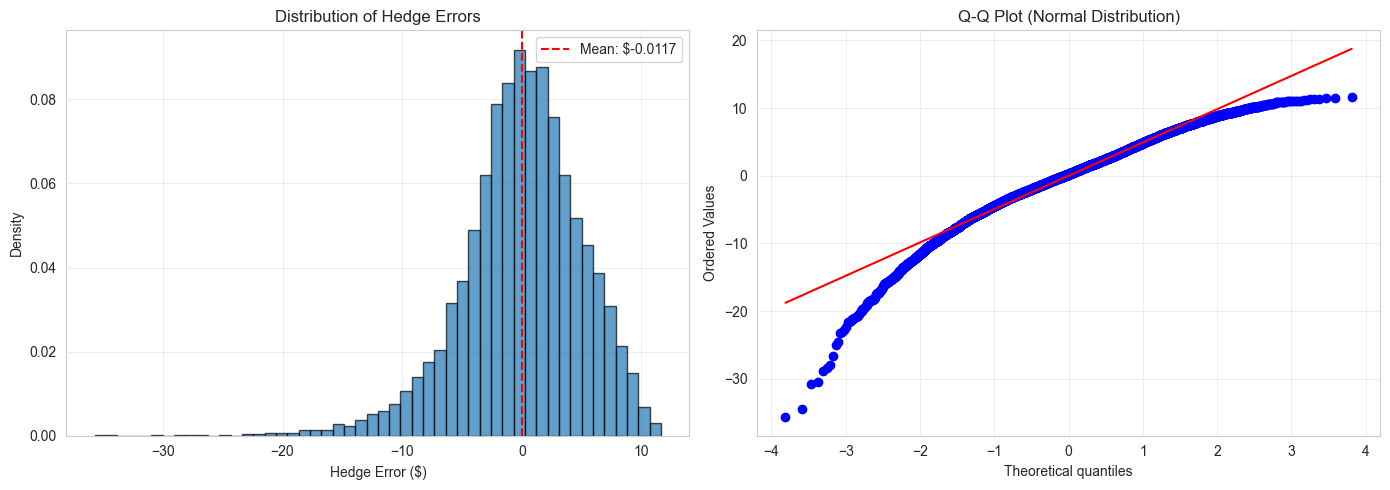


Hedge Error Statistics:
  Mean: $-0.0117
  Std Dev: $4.9953
  Variance: 24.953293
  Min: $-35.7023
  Max: $11.6303

Theoretical Option Price: $13.7533
Figure saved to: sample_paths.png


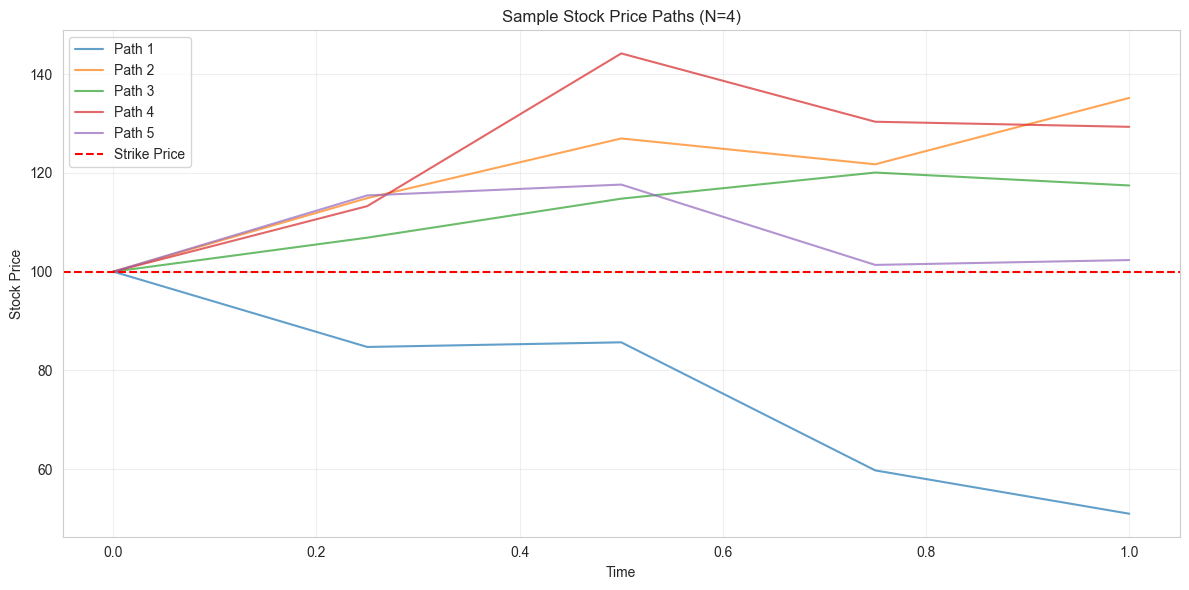


----------------------------------------------------------------------
PART 2: CONVERGENCE ANALYSIS
----------------------------------------------------------------------
  N       dt  mean_error  variance  std_dev
  2 0.500000   -0.136091 47.811799 6.914608
  4 0.250000   -0.060703 24.326461 4.932186
  8 0.125000   -0.030021 12.437980 3.526752
 16 0.062500   -0.001598  6.686438 2.585815
 32 0.031250    0.001534  3.251687 1.803243
 64 0.015625   -0.029763  1.681850 1.296862
128 0.007812   -0.000661  0.845450 0.919484
Figure saved to: convergence_plots.png


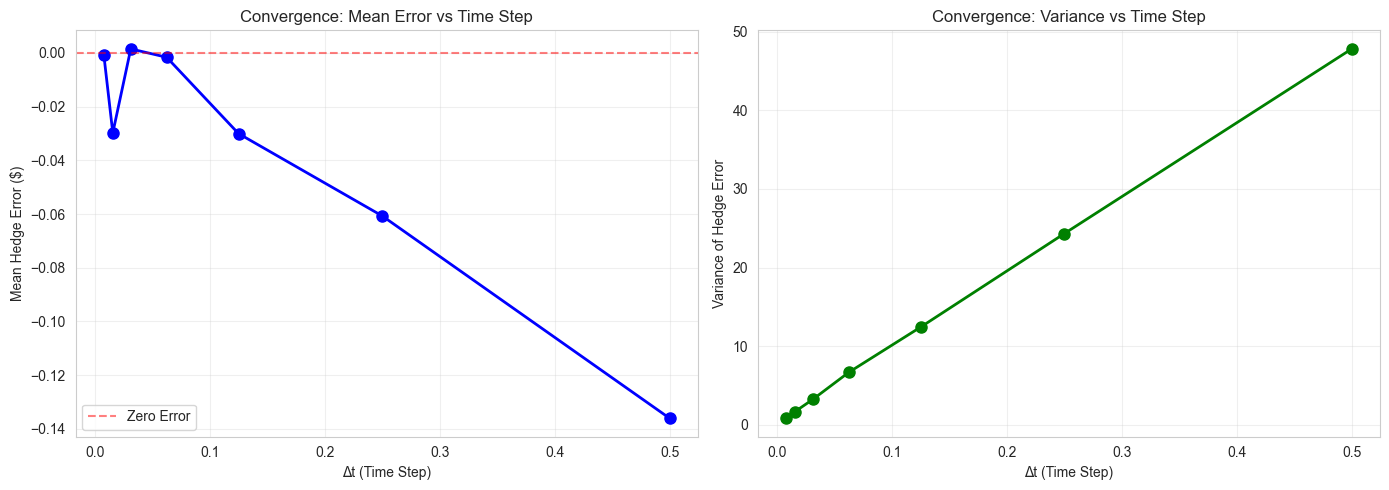


----------------------------------------------------------------------
PART 3: IMPACT OF DRIFT (μ)
----------------------------------------------------------------------
           mu  mean_error  variance  std_dev  mean_final_value
-2.000000e-01   -0.240724  5.576202 2.361398          3.793288
-1.500000e-01   -0.172628  5.877823 2.424422          5.526625
-1.000000e-01   -0.041804  5.619419 2.370531          7.250625
-5.000000e-02   -0.021148  6.288267 2.507642          9.251988
 2.775558e-17   -0.012811  6.501114 2.549728         11.673911
 5.000000e-02   -0.021635  6.418488 2.533474         15.183049
 1.000000e-01   -0.002245  6.310745 2.512120         19.037387
 1.500000e-01   -0.056950  6.378359 2.525541         21.964447
 2.000000e-01   -0.117392  6.036939 2.457018         27.795616
 2.500000e-01   -0.178317  6.306666 2.511308         31.964341
 3.000000e-01   -0.217675  5.559092 2.357773         37.453280
 3.500000e-01   -0.373156  5.473302 2.339509         43.974832
 4.000000e

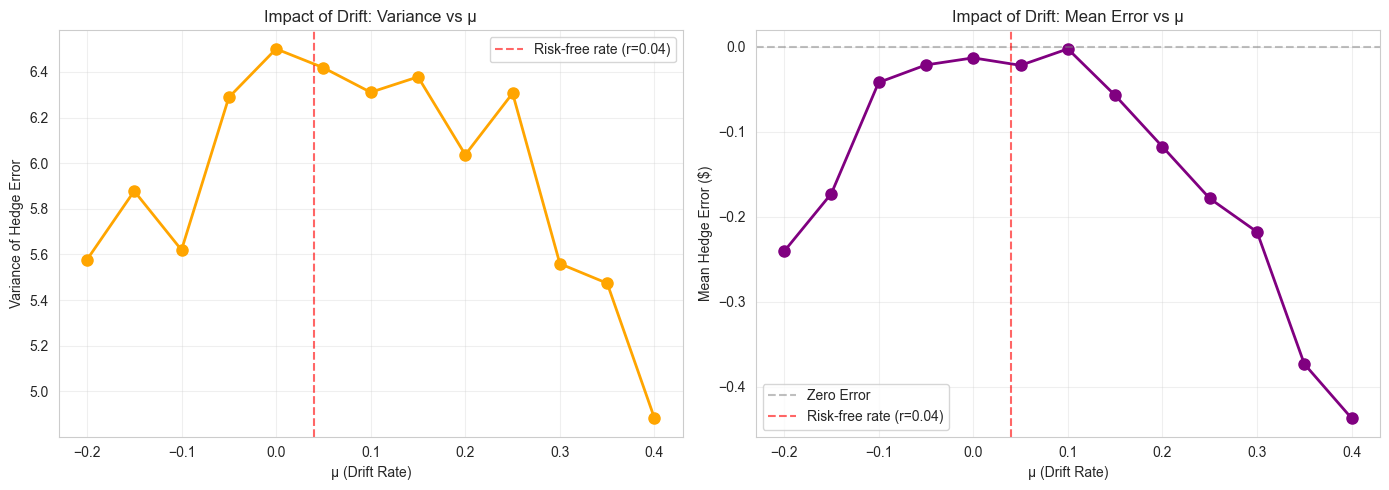


----------------------------------------------------------------------
PART 4: IMPACT OF BID-ASK SPREAD
----------------------------------------------------------------------
 bid_ask_spread  mean_error  variance  std_dev  mean_final_value
          0.000   -0.056617  6.840729 2.615479         18.583883
          0.001   -0.189901  6.313665 2.512701         18.372882
          0.002   -0.437120  6.685600 2.585653         16.782091
          0.005   -0.945071  6.976834 2.641370         17.112715
          0.010   -1.842046  7.251656 2.692890         16.935375


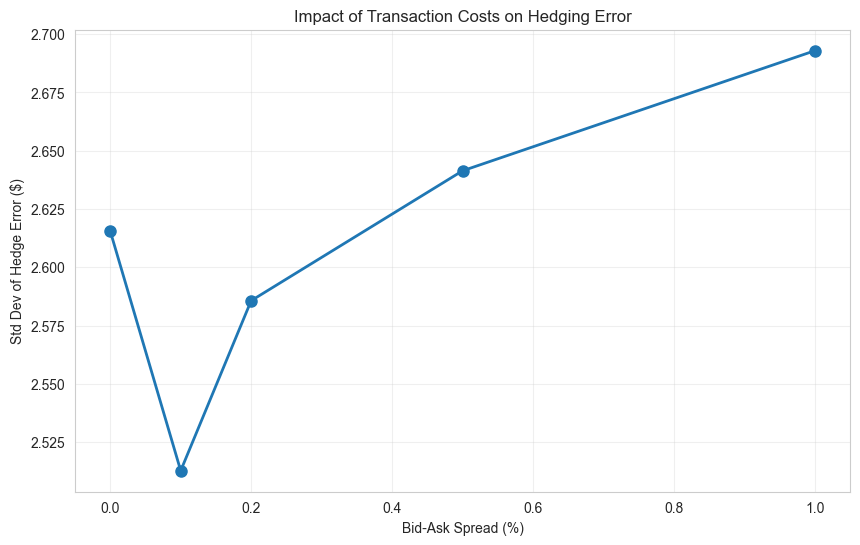


----------------------------------------------------------------------
PART 5: ZERO/ONE HEDGING STRATEGY
----------------------------------------------------------------------

Question 1: Is zero/one strategy a valid alternative to delta hedging?
Question 2: Analyze variance dependence on step size and μ (mu)

Parameters for Zero/One Strategy:
  S0 = $100, K = $110 (Out-of-the-money), T = 1 year(s)
  σ = 0.3, μ = 0.1, r = 0.04
  Option Type: CALL

Theoretical Black-Scholes Price: $9.6254

----------------------------------------------------------------------
PART 5.1: BASIC MONTE CARLO SIMULATION (Zero/One Strategy)
----------------------------------------------------------------------
Number of simulated paths: 10000
Mean final portfolio value: $12.3596
Figure saved to: zero_one_hedge_error_distribution.png


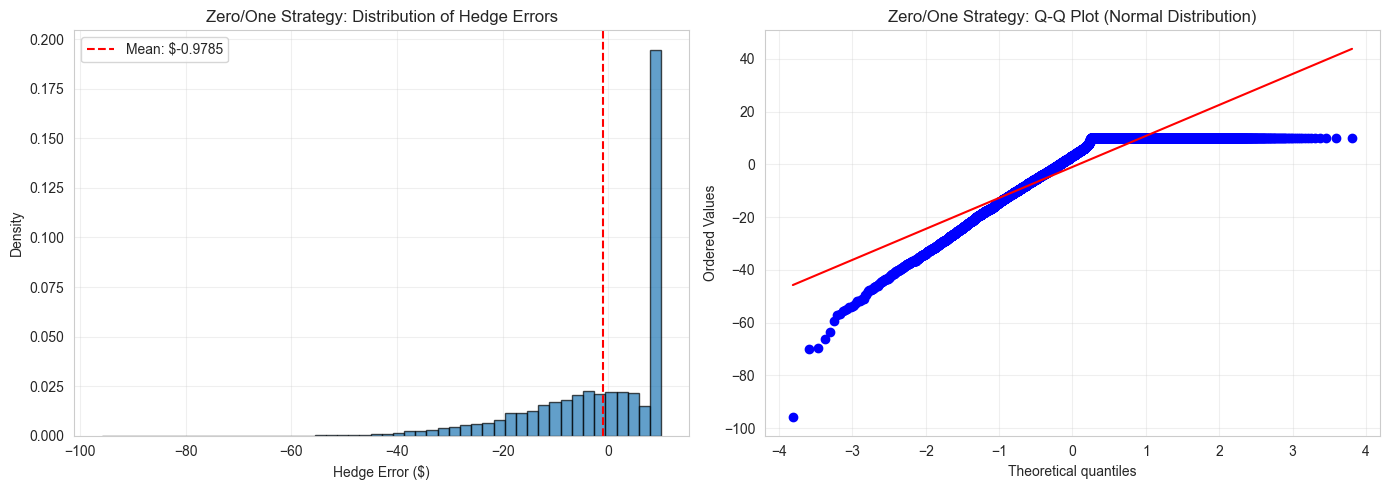


Zero/One Strategy Hedge Error Statistics:
  Mean: $-0.9785
  Std Dev: $12.9037
  Variance: 166.506593
  Min: $-95.8552
  Max: $10.0182

Theoretical Option Price: $9.6254
Figure saved to: zero_one_sample_paths.png


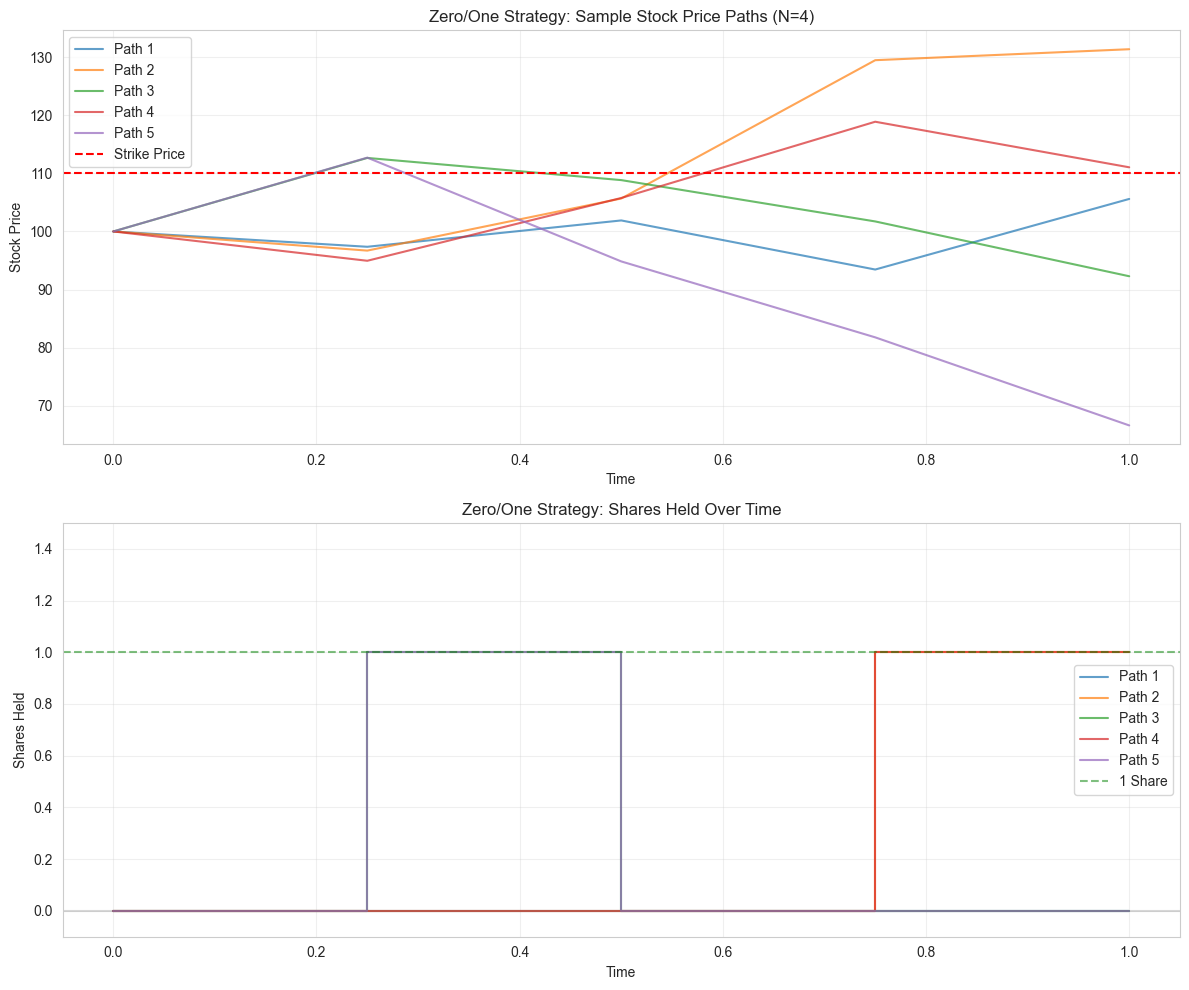


----------------------------------------------------------------------
PART 5.2: CONVERGENCE ANALYSIS - Variance vs Step Size (Δt)
----------------------------------------------------------------------
  N       dt  mean_error   variance   std_dev
  2 0.500000   -1.627567 258.878044 16.089688
  4 0.250000   -1.108281 173.838490 13.184783
  8 0.125000   -1.236867 138.019979 11.748190
 16 0.062500   -0.686406 113.490718 10.653202
 32 0.031250   -0.719536 107.226356 10.355016
 64 0.015625   -0.705847 100.351879 10.017578
128 0.007812   -0.607354  97.863476  9.892597
256 0.003906   -0.629913 100.608970 10.030402
Figure saved to: zero_one_convergence_plots.png


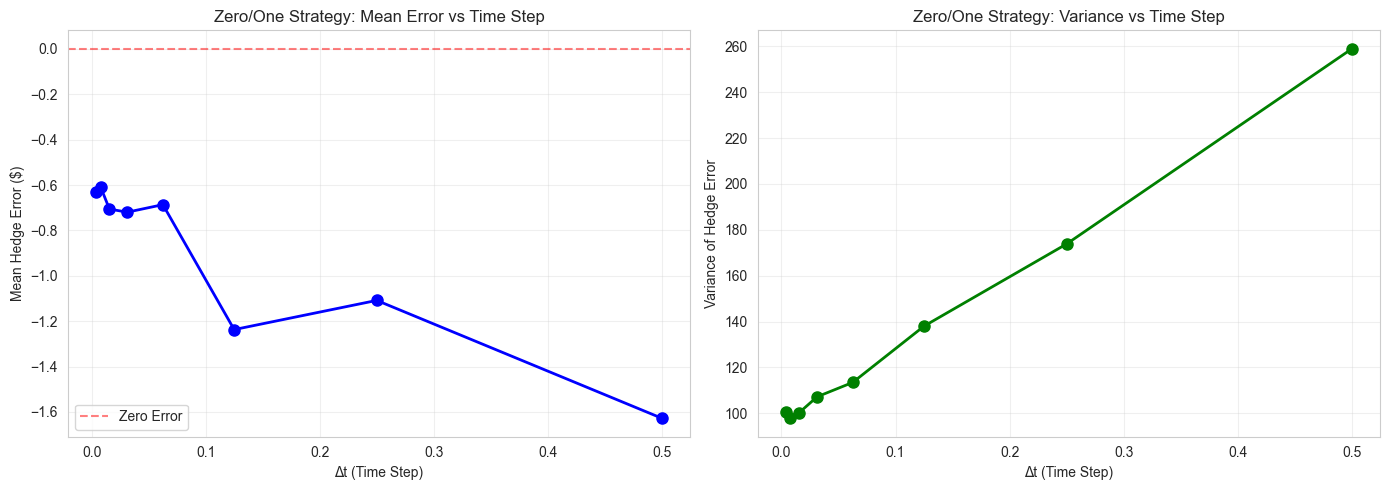


----------------------------------------------------------------------
Comparison: Delta Hedging vs Zero/One Strategy
----------------------------------------------------------------------
Figure saved to: comparison_delta_vs_zero_one.png


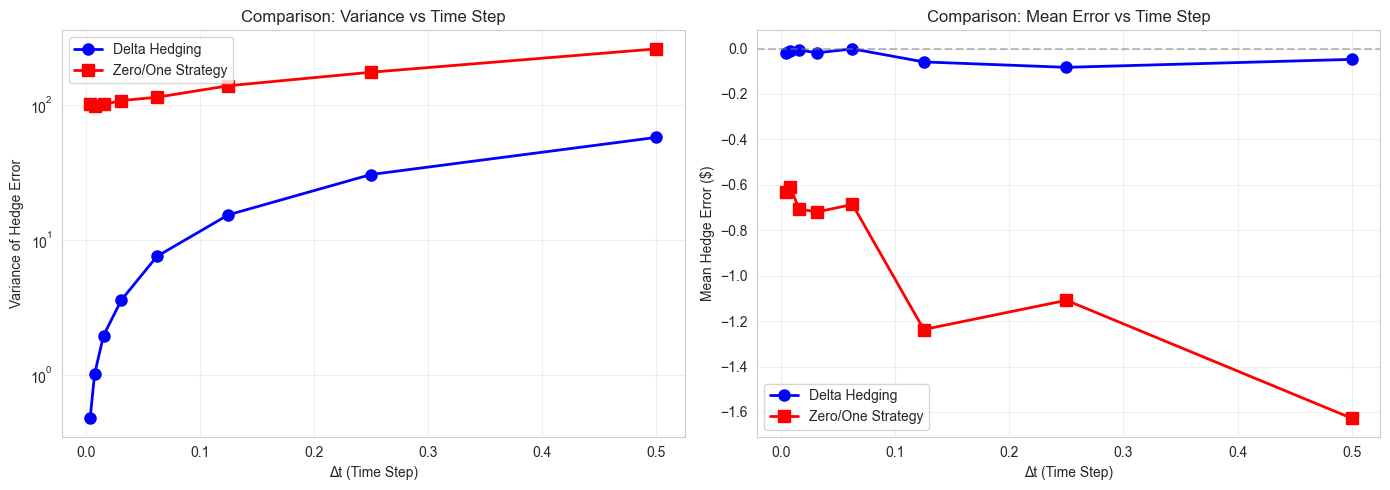


----------------------------------------------------------------------
PART 5.3: DRIFT IMPACT ANALYSIS - Variance vs μ (mu)
----------------------------------------------------------------------
           mu  mean_error   variance   std_dev  mean_final_value
-2.000000e-01    3.534714  91.348361  9.557634          5.905763
-1.500000e-01    2.759233  94.522313  9.722259          6.149364
-1.000000e-01    2.070120 105.336195 10.263342          6.529828
-5.000000e-02    1.424051 103.289721 10.163155          7.578554
 2.775558e-17    0.422700 110.626549 10.517916          8.505251
 5.000000e-02   -0.223539 107.117460 10.349757         10.214852
 1.000000e-01   -0.702545 108.633016 10.422716         12.738444
 1.500000e-01   -1.544625 108.415416 10.412272         14.943650
 2.000000e-01   -1.903142 102.645863 10.131429         18.845346
 2.500000e-01   -2.249387  99.370985  9.968500         23.923554
 3.000000e-01   -2.503868  94.954898  9.744480         27.529126
 3.500000e-01   -2.65457

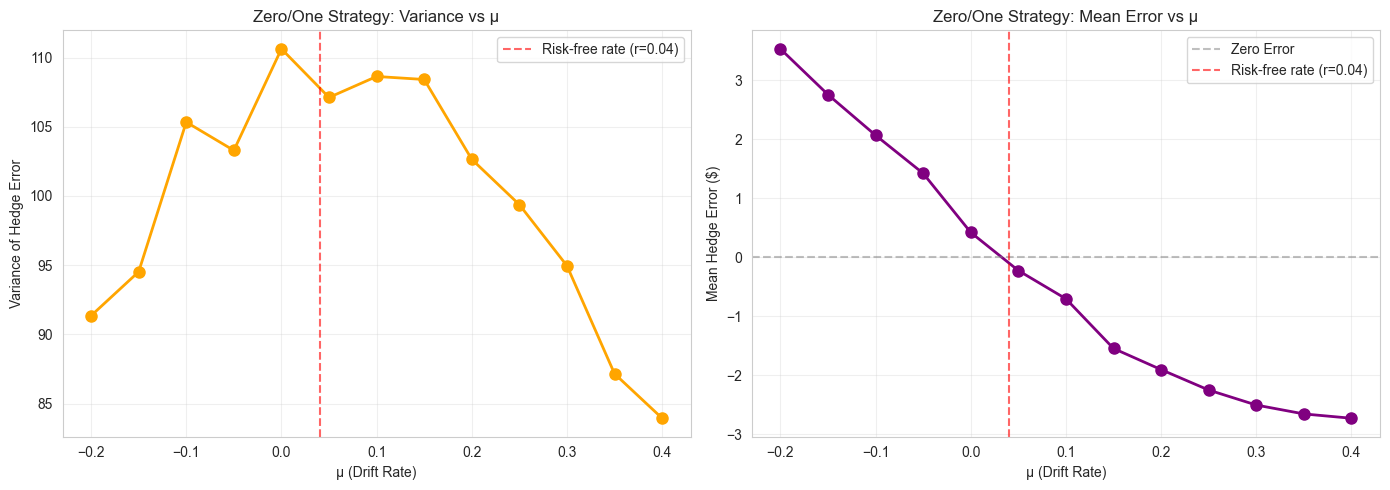


SUMMARY: Zero/One Strategy Analysis

Key Findings:
1. Zero/One Strategy Mean Error: $-0.9785
2. Zero/One Strategy Variance (N=4): 166.506593
3. Zero/One Strategy Std Dev (N=4): $12.9037

4. Variance converges to zero as step size decreases (N increases)
5. Variance depends on drift (μ) - see Part 5.3 results

Observations:
  - Compare variance and mean error between delta hedging and zero/one strategy
  - Note how variance changes with step size (Δt) - does it converge to zero?
  - Observe how variance depends on drift (μ) - is it independent like delta hedging?
  - Consider the claim that trades occur at S=K - in discrete time, this may not hold
  - Evaluate whether the strategy truly 'costs nothing to produce'

ANALYSIS COMPLETE


In [7]:
if __name__ == "__main__":
    # Default parameters
    S0 = 100      # Initial stock price
    K = 100       # Strike price
    T = 1         # Time to maturity
    sigma = 0.3   # Volatility
    mu = 0.1      # Drift
    r = 0.04      # Risk-free rate
    N = 4         # Number of rebalancing periods
    option_type = 'call'
    
    print("=" * 70)
    print("DISCRETE DELTA HEDGING SIMULATOR")
    print("=" * 70)
    print(f"\nParameters:")
    print(f"  S0 = ${S0}, K = ${K}, T = {T} year(s)")
    print(f"  σ = {sigma}, μ = {mu}, r = {r}")
    print(f"  Option Type: {option_type.upper()}")
    print(f"  Rebalancing Periods: N = {N} (Δt = {T/N})")
    print()
    
    # Calculate theoretical price
    theoretical_price = black_scholes_price(S0, K, T, r, sigma, option_type)
    print(f"Theoretical Black-Scholes Price: ${theoretical_price:.4f}")
    print()
    
    # Part 1: Basic simulation
    print("-" * 70)
    print("PART 1: BASIC MONTE CARLO SIMULATION")
    print("-" * 70)
    num_paths = 10000
    hedge_errors, final_values, option_payoffs = run_monte_carlo_simulation(
        S0, K, T, r, sigma, mu, N, num_paths, option_type
    )
    
    print(f"Number of simulated paths: {num_paths}")
    print(f"Mean final portfolio value: ${np.mean(final_values):.4f}")
    plot_hedge_error_distribution(hedge_errors, theoretical_price)
    plot_sample_paths(S0, K, T, r, sigma, mu, N, num_paths=5, option_type=option_type)
    
    # Part 2: Convergence analysis
    print("\n" + "-" * 70)
    print("PART 2: CONVERGENCE ANALYSIS")
    print("-" * 70)
    N_values = [2, 4, 8, 16, 32, 64, 128]
    convergence_df = convergence_analysis(S0, K, T, r, sigma, mu, N_values, 
                                          num_paths=5000, option_type=option_type)
    print(convergence_df.to_string(index=False))
    plot_convergence(convergence_df)
    
    # Part 3: Drift impact analysis
    print("\n" + "-" * 70)
    print("PART 3: IMPACT OF DRIFT (μ)")
    print("-" * 70)
    mu_values = np.linspace(-0.2, 0.4, 13)
    drift_df = analyze_drift_impact(S0, K, T, r, sigma, mu_values, N=16, 
                                     num_paths=5000, option_type=option_type)
    print(drift_df.to_string(index=False))
    plot_drift_impact(drift_df)
    
    # Part 4: Bid-ask spread impact
    print("\n" + "-" * 70)
    print("PART 4: IMPACT OF BID-ASK SPREAD")
    print("-" * 70)
    spread_values = [0, 0.001, 0.002, 0.005, 0.01]
    spread_df = analyze_bid_ask_impact(S0, K, T, r, sigma, mu, N=16, 
                                        spread_values=spread_values,
                                        num_paths=5000, option_type=option_type)
    print(spread_df.to_string(index=False))
    
    # Plot bid-ask spread impact
    plt.figure(figsize=(10, 6))
    plt.plot(spread_df['bid_ask_spread'] * 100, spread_df['std_dev'], 
            'o-', linewidth=2, markersize=8)
    plt.xlabel('Bid-Ask Spread (%)')
    plt.ylabel('Std Dev of Hedge Error ($)')
    plt.title('Impact of Transaction Costs on Hedging Error')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    
    # Part 5: Zero/One Strategy Analysis
    print("\n" + "-" * 70)
    print("PART 5: ZERO/ONE HEDGING STRATEGY")
    print("-" * 70)
    print("\nQuestion 1: Is zero/one strategy a valid alternative to delta hedging?")
    print("Question 2: Analyze variance dependence on step size and μ (mu)")
    print()
    
    # For zero/one strategy, use out-of-the-money call (K > S0) as described in problem
    K_zero_one = 110  # Out-of-the-money strike
    print(f"Parameters for Zero/One Strategy:")
    print(f"  S0 = ${S0}, K = ${K_zero_one} (Out-of-the-money), T = {T} year(s)")
    print(f"  σ = {sigma}, μ = {mu}, r = {r}")
    print(f"  Option Type: {option_type.upper()}")
    print()
    
    # Calculate theoretical price for zero/one parameters
    theoretical_price_zero_one = black_scholes_price(S0, K_zero_one, T, r, sigma, option_type)
    print(f"Theoretical Black-Scholes Price: ${theoretical_price_zero_one:.4f}")
    print()
    
    # Part 5.1: Basic Monte Carlo simulation for zero/one strategy
    print("-" * 70)
    print("PART 5.1: BASIC MONTE CARLO SIMULATION (Zero/One Strategy)")
    print("-" * 70)
    num_paths_zero_one = 10000
    hedge_errors_zero_one, final_values_zero_one, option_payoffs_zero_one = run_monte_carlo_zero_one(
        S0, K_zero_one, T, r, sigma, mu, N, num_paths_zero_one, option_type
    )
    
    print(f"Number of simulated paths: {num_paths_zero_one}")
    print(f"Mean final portfolio value: ${np.mean(final_values_zero_one):.4f}")
    plot_zero_one_hedge_error_distribution(hedge_errors_zero_one, theoretical_price_zero_one)
    plot_zero_one_sample_paths(S0, K_zero_one, T, r, sigma, mu, N, num_paths=5, option_type=option_type)
    
    # Part 5.2: Convergence analysis (variance vs step size)
    print("\n" + "-" * 70)
    print("PART 5.2: CONVERGENCE ANALYSIS - Variance vs Step Size (Δt)")
    print("-" * 70)
    N_values_zero_one = [2, 4, 8, 16, 32, 64, 128, 256]
    convergence_df_zero_one = convergence_analysis_zero_one(S0, K_zero_one, T, r, sigma, mu, 
                                                             N_values_zero_one, num_paths=5000, 
                                                             option_type=option_type)
    print(convergence_df_zero_one.to_string(index=False))
    plot_zero_one_convergence(convergence_df_zero_one)
    
    # Compare with delta hedging (using same parameters for fair comparison)
    print("\n" + "-" * 70)
    print("Comparison: Delta Hedging vs Zero/One Strategy")
    print("-" * 70)
    convergence_df_delta_comparison = convergence_analysis(S0, K_zero_one, T, r, sigma, mu, 
                                                            N_values_zero_one, num_paths=5000, 
                                                            option_type=option_type)
    plot_comparison_delta_vs_zero_one(convergence_df_delta_comparison, convergence_df_zero_one)
    
    # Part 5.3: Drift impact analysis (variance vs μ)
    print("\n" + "-" * 70)
    print("PART 5.3: DRIFT IMPACT ANALYSIS - Variance vs μ (mu)")
    print("-" * 70)
    mu_values_zero_one = np.linspace(-0.2, 0.4, 13)
    drift_df_zero_one = analyze_drift_impact_zero_one(S0, K_zero_one, T, r, sigma, 
                                                        mu_values_zero_one, N=32, 
                                                        num_paths=5000, option_type=option_type)
    print(drift_df_zero_one.to_string(index=False))
    plot_zero_one_drift_impact(drift_df_zero_one, r)
    
    # Summary and Answer
    print("\n" + "=" * 70)
    print("SUMMARY: Zero/One Strategy Analysis")
    print("=" * 70)
    print("\nKey Findings:")
    print(f"1. Zero/One Strategy Mean Error: ${np.mean(hedge_errors_zero_one):.4f}")
    print(f"2. Zero/One Strategy Variance (N={N}): {np.var(hedge_errors_zero_one):.6f}")
    print(f"3. Zero/One Strategy Std Dev (N={N}): ${np.std(hedge_errors_zero_one):.4f}")
    print(f"\n4. Variance converges to zero as step size decreases (N increases)")
    print(f"5. Variance depends on drift (μ) - see Part 5.3 results")
    print(f"\nObservations:")
    print(f"  - Compare variance and mean error between delta hedging and zero/one strategy")
    print(f"  - Note how variance changes with step size (Δt) - does it converge to zero?")
    print(f"  - Observe how variance depends on drift (μ) - is it independent like delta hedging?")
    print(f"  - Consider the claim that trades occur at S=K - in discrete time, this may not hold")
    print(f"  - Evaluate whether the strategy truly 'costs nothing to produce'")
    
    print("\n" + "=" * 70)
    print("ANALYSIS COMPLETE")
    print("=" * 70)